In [1]:
using Yao
using YaoPlots
using Plots
using LinearAlgebra
using BitBasis

include("../src/QuantumPrimer.jl")
using .QuantumPrimer

4×4 Matrix{ComplexF64}:
 0.25+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im
  0.0+0.0im  0.25+0.0im   0.0+0.0im   0.0+0.0im
  0.0+0.0im   0.0+0.0im  0.25+0.0im   0.0+0.0im
  0.0+0.0im   0.0+0.0im   0.0+0.0im  0.25+0.0im

4×4 Matrix{ComplexF64}:
 0.25+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im
  0.0+0.0im  0.25+0.0im   0.0+0.0im   0.0+0.0im
  0.0+0.0im   0.0+0.0im  0.25+0.0im   0.0+0.0im
  0.0+0.0im   0.0+0.0im   0.0+0.0im  0.25+0.0im

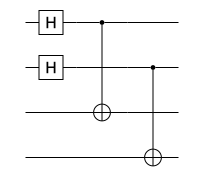

In [3]:
display(partial_tr(density_matrix(zero_state(4) |> circ_purified_maximally_mixed(2)), [3, 4]).state)
display(completely_mixed_state(2) |> state)

circ_purified_maximally_mixed(2) |> YaoPlots.plot

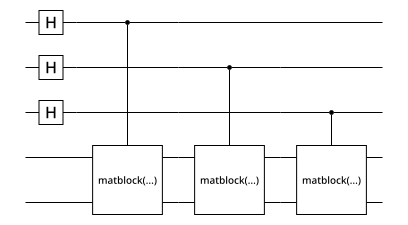

In [4]:
circ_phase_encoding(3, Matrix(circ_haar_random_unitary(2)), reverse_qubits=false) |> YaoPlots.plot

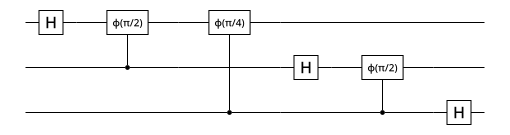

In [5]:
circ_qft(3; reverse_qubits=false) |> YaoPlots.plot

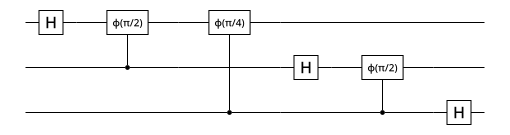

In [6]:
EasyBuild.qft_circuit(3) |> YaoPlots.plot

The following 2 QPE circuits are the same with the only difference that the register-qubits ordering is swapped. The first one follows Yao convention, the second one follows the rest of the world.

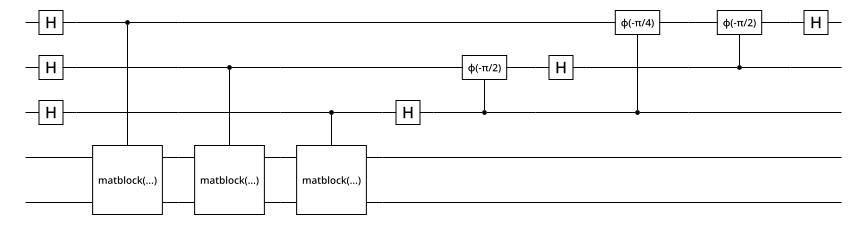

In [7]:
ControlU(n, m, U) = chain(n+m, control(k, n+1:n+m=>matblock(U^(2^(k-1)))) for k in 1:n)
PE(n, m, U) =
    chain(n+m, # total number of the qubits
        subroutine(circ_Hn(n), 1:n), # apply H in local scope
        ControlU(n, m, U),
        subroutine(EasyBuild.qft_circuit(n)', 1:n))

PE(3, 2, circ_haar_random_unitary(2)) |> YaoPlots.plot

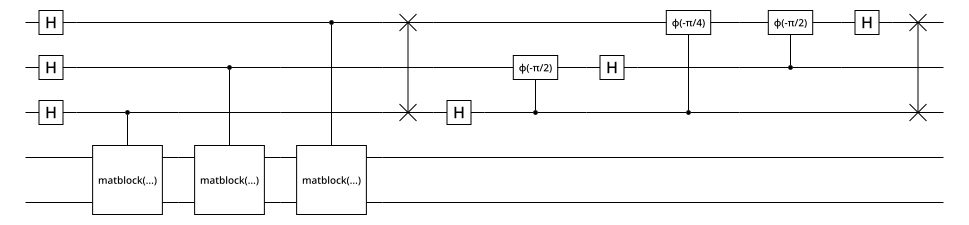

In [8]:
circ_qpe(3, circ_haar_random_unitary(2); reverse_qubits=true) |> YaoPlots.plot

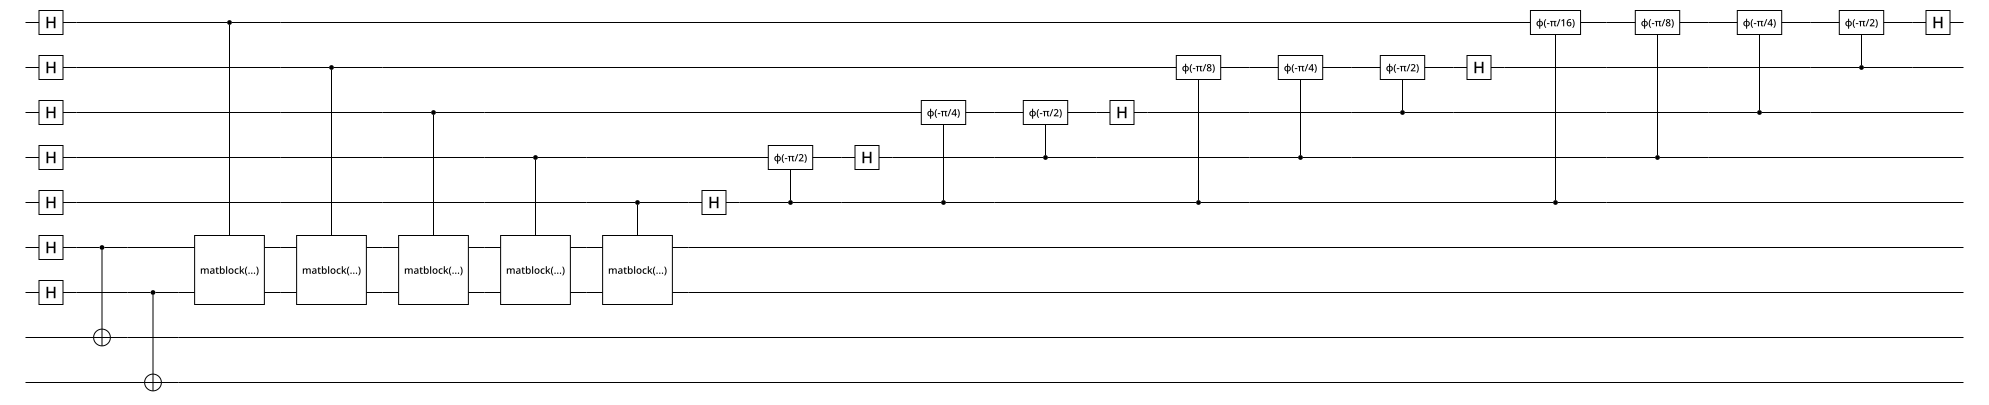

In [9]:
ccc = circ_append_ancillas(circ_purified_maximally_mixed(2), 5; pos_ancillas=:top)
push!(ccc, circ_append_ancillas(circ_qpe(5, circ_haar_random_unitary(2)), 2))
ccc |> YaoPlots.plot

### Single eigenvector

0.1854501678474807


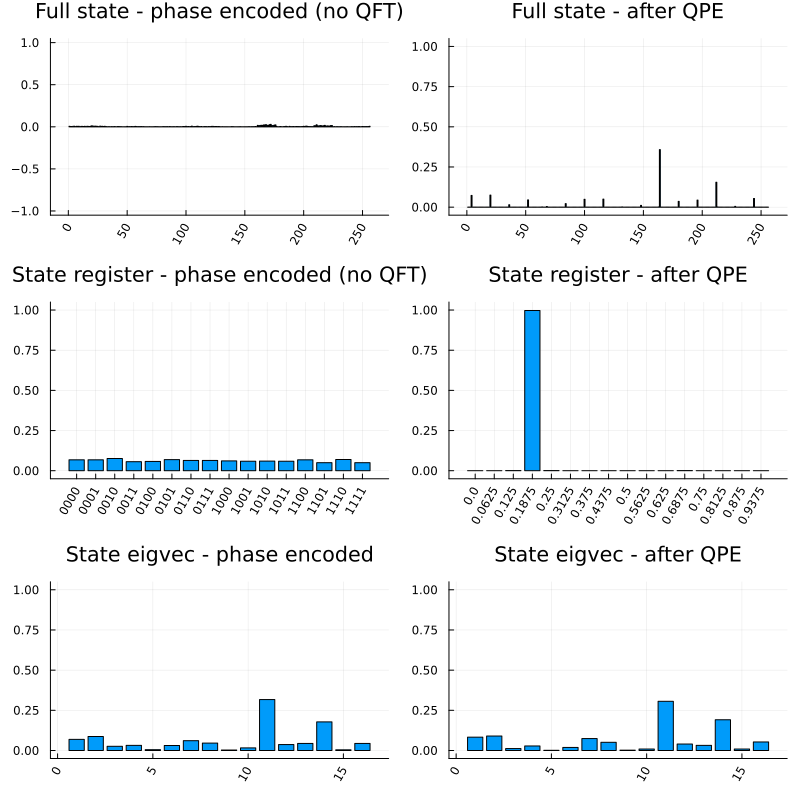

In [10]:
# Single eigenvector

n_times = 4 # dimension time register
eig_idx = 3 # index of the eigenvalue to be read out
nshots = 1000

# Create diagonal matrix, rotate it, and find again eigenvalues and eigenvectors
# hamiltonian_matrix = diagm([0.25, 0.75])
# hamiltonian_matrix = diagm([0.125, 0.375, 0.4375, 0.75])
hamiltonian_matrix = diagm(sort(rand(Float64, 2^4)))
println(diag(hamiltonian_matrix)[eig_idx])

# rotation_matrix = I
# rotation_matrix = eigen(rand_unitary(length(diag(hamiltonian_matrix)))).vectors
rotation_matrix = rand_unitary(length(diag(hamiltonian_matrix)))

hamiltonian_matrix_rot = rotation_matrix * hamiltonian_matrix * rotation_matrix'
eigenvalues, eigenvectors = eigen(hamiltonian_matrix_rot) # the i-th eigenvector is eigenvectors[:, i]
n_qubits = Int(log2(length(eigenvalues)))
unitary = exp(1im * 2π * hamiltonian_matrix_rot)

eigvec_state = ArrayReg(Complex.(eigenvectors[:, eig_idx]))
# eigvec_state = zero_state(2 * n_qubits)
register_state = zero_state(n_times)
initial_state = join(eigvec_state, register_state)

state_phase_encoded = copy(initial_state) |> circ_phase_encoding(n_times, unitary; reverse_qubits=false) |> chain(n_times+n_qubits, put(1:n_times => circ_reverse_order(n_times))) # reverse the readout if using Yao convention
meas_full_phase_encoded = measure(state_phase_encoded, 1:n_times+n_qubits; nshots=nshots)
counts_full_phase_encoded = [count(x->x==i, meas_full_phase_encoded) for i in 0:2^(n_times+n_qubits)-1] / nshots
meas_register_phase_encoded = measure(state_phase_encoded, 1:n_times; nshots=nshots)
counts_register_phase_encoded = [count(x->x==i, meas_register_phase_encoded) for i in 0:2^n_times-1] / nshots
meas_eigvec_phase_encoded = measure(state_phase_encoded, n_times+1:n_times+n_qubits; nshots=nshots)
counts_eigvec_phase_encoded = [count(x->x==i, meas_eigvec_phase_encoded) for i in 0:2^n_qubits-1] / nshots

state_after_qpe = copy(initial_state) |> circ_qpe(n_times, unitary; reverse_qubits=false) |> chain(n_times+n_qubits, put(1:n_times => circ_reverse_order(n_times))) # reverse the readout if using Yao convention
meas_full_after_qpe = measure(state_after_qpe, 1:n_times+n_qubits; nshots=nshots)
counts_full_after_qpe = [count(x->x==i, meas_full_after_qpe) for i in 0:2^(n_times+n_qubits)-1] / nshots
meas_register_after_qpe = measure(state_after_qpe, 1:n_times; nshots=nshots)
counts_register_after_qpe = [count(x->x==i, meas_register_after_qpe) for i in 0:2^n_times-1] / nshots
meas_eigvec_after_qpe = measure(state_after_qpe, n_times+1:n_times+n_qubits; nshots=nshots)
counts_eigvec_after_qpe = [count(x->x==i, meas_eigvec_after_qpe) for i in 0:2^n_qubits-1] / nshots

# xx = [(x-1)/2^n_times for x in 1:2^n_times]
xx = [bfloat_r(x-1, nbits=n_times) for x in 1:2^n_times]

p1 = Plots.plot(counts_full_phase_encoded, legend=false, title="Full state - phase encoded (no QFT)", xrotation=60, ylims=(-1.05, 1.05), seriestype=:bar, color=1)
# xticks!(1:2^(n_times+n_qubits), [string(x-1, base=2, pad=n_times+n_qubits) for x in 1:2^(n_times+n_qubits)])
p2 = Plots.plot(1:2^(n_times+n_qubits), counts_full_after_qpe, legend=false, title="Full state - after QPE", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar, color=1)
# xticks!(1:2^(n_times+n_qubits), [string(x-1, base=2, pad=n_times+n_qubits) for x in 1:2^(n_times+n_qubits)])
# p3 = Plots.plot(imag.(reg_phase_encoded), legend=false, title="State register - phase encoded (no QFT)", xrotation=60, ylims=(-1.05, 1.05), seriestype=:bar)
p3 = Plots.plot(counts_register_phase_encoded, legend=false, title="State register - phase encoded (no QFT)", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
# xticks!(1:2^n_times, [string(i-1) for i in 1:2^n_times])
xticks!(1:2^n_times, [string(x-1, base=2, pad=n_times) for x in 1:2^n_times])
# xticks!(1:2^n_times, [string((x-1)/2^n_times) for x in 1:2^n_times])
p4 = Plots.plot([(x-1)/2^n_times for x in 1:2^n_times], counts_register_after_qpe, legend=false, title="State register - after QPE", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
# Plots.plot!([real(i) for i in eigenvalues], color=:gray, label="", seriestype=:vline, linestyle=:dash, linewidth=2, alpha=0.8)
# xticks!(1:2^n_times, [string(i-1) for i in 1:2^n_times])
# xticks!([(x-1)/2^n_times for x in 1:2^n_times], [string(x-1, base=2, pad=n_times) for x in 1:2^n_times])
xticks!(xx, string.(xx))
p5 = Plots.plot(counts_eigvec_phase_encoded, legend=false, title="State eigvec - phase encoded", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
p6 = Plots.plot(counts_eigvec_after_qpe, legend=false, title="State eigvec - after QPE", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
Plots.plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(800, 800))

### Purified maximally mixed state

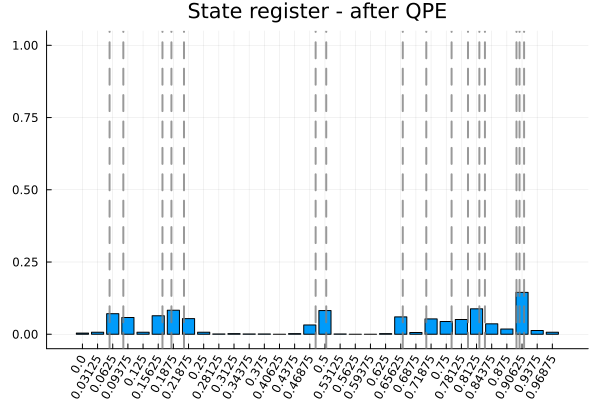

In [11]:
# Purified maximally mixed state

n_times = 5 # dimension time register
eig_idx = 3 # index of the eigenvalue to be read out
nshots = 1000

# Create diagonal matrix, rotate it, and find again eigenvalues and eigenvectors
hamiltonian_matrix = diagm([0.125, 0.375, 0.4375, 0.75])
hamiltonian_matrix = diagm(sort(rand(Float64, 2^4)))

# rotation_matrix = I
# rotation_matrix = eigen(rand_unitary(length(diag(hamiltonian_matrix)))).vectors
rotation_matrix = rand_unitary(length(diag(hamiltonian_matrix)))

hamiltonian_matrix_rot = rotation_matrix * hamiltonian_matrix * rotation_matrix'
eigenvalues, eigenvectors = eigen(hamiltonian_matrix_rot) # the i-th eigenvector is eigenvectors[:, i]
n_qubits = Int(log2(length(eigenvalues)))
unitary = exp(1im * 2π * hamiltonian_matrix_rot)

all_n = n_times + 2n_qubits # include the ancilla qubits for purification

# eigvec_state = ArrayReg(Complex.(eigenvectors[:, eig_idx]))
# eigvec_state = zero_state(2 * n_qubits)
# register_state = zero_state(n_times)
# initial_state = join(eigvec_state, register_state)
initial_state = zero_state(all_n)
initial_state |> circ_append_ancillas(circ_purified_maximally_mixed(n_qubits), n_times; pos_ancillas=:top)

state_phase_encoded = copy(initial_state) |> circ_append_ancillas(circ_phase_encoding(n_times, unitary; reverse_qubits=false), n_qubits) |> chain(all_n, put(1:n_times => circ_reverse_order(n_times))) # reverse the readout if using Yao convention
meas_full_phase_encoded = measure(state_phase_encoded, 1:all_n; nshots=nshots)
counts_full_phase_encoded = [count(x->x==i, meas_full_phase_encoded) for i in 0:2^(all_n)-1] / nshots
meas_register_phase_encoded = measure(state_phase_encoded, 1:n_times; nshots=nshots)
counts_register_phase_encoded = [count(x->x==i, meas_register_phase_encoded) for i in 0:2^n_times-1] / nshots
meas_eigvec_phase_encoded = measure(state_phase_encoded, n_times+1:all_n; nshots=nshots)
counts_eigvec_phase_encoded = [count(x->x==i, meas_eigvec_phase_encoded) for i in 0:2^n_qubits-1] / nshots

state_after_qpe = copy(initial_state) |> circ_append_ancillas(circ_qpe(n_times, unitary; reverse_qubits=false), n_qubits) |> chain(all_n, put(1:n_times => circ_reverse_order(n_times))) # reverse the readout if using Yao convention
meas_full_after_qpe = measure(state_after_qpe, 1:all_n; nshots=nshots)
counts_full_after_qpe = [count(x->x==i, meas_full_after_qpe) for i in 0:2^(all_n)-1] / nshots
meas_register_after_qpe = measure(state_after_qpe, 1:n_times; nshots=nshots)
counts_register_after_qpe = [count(x->x==i, meas_register_after_qpe) for i in 0:2^n_times-1] / nshots
meas_eigvec_after_qpe = measure(state_after_qpe, n_times+1:all_n; nshots=nshots)
counts_eigvec_after_qpe = [count(x->x==i, meas_eigvec_after_qpe) for i in 0:2^n_qubits-1] / nshots

xx = [bfloat_r(x-1, nbits=n_times) for x in 1:2^n_times] # same as [(x-1)/2^n_times for x in 1:2^n_times]

# Plot - 3x2 grid
# p1 = Plots.plot(counts_full_phase_encoded, legend=false, title="Full state - phase encoded (no QFT)", xrotation=60, ylims=(-1.05, 1.05), seriestype=:bar, color=1)
# p2 = Plots.plot(1:2^(all_n), counts_full_after_qpe, legend=false, title="Full state - after QPE", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar, color=1)
# p3 = Plots.plot(counts_register_phase_encoded, legend=false, title="State register - phase encoded (no QFT)", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
# xticks!(1:2^n_times, [string(x-1, base=2, pad=n_times) for x in 1:2^n_times])
# p4 = Plots.plot([(x-1)/2^n_times for x in 1:2^n_times], counts_register_after_qpe, legend=false, title="State register - after QPE", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
# Plots.plot!([real(i) for i in eigenvalues], color=:gray, label="", seriestype=:vline, linestyle=:dash, linewidth=2, alpha=0.8)
# xticks!(xx, string.(xx))
# p5 = Plots.plot(counts_eigvec_phase_encoded, legend=false, title="State eigvec - phase encoded", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
# p6 = Plots.plot(counts_eigvec_after_qpe, legend=false, title="State eigvec - after QPE", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
# Plots.plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(800, 800))

# Plot - register state after QPE
Plots.plot([(x-1)/2^n_times for x in 1:2^n_times], counts_register_after_qpe, legend=false, title="State register - after QPE", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
Plots.plot!([real(i) for i in eigenvalues], color=:gray, label="", seriestype=:vline, linestyle=:dash, linewidth=2, alpha=0.8)
xticks!(xx, string.(xx))

### Example generation DOS-encoded state

ArrayReg{2, ComplexF64, Array...}
    active qubits: 5/13
    nlevel: 2


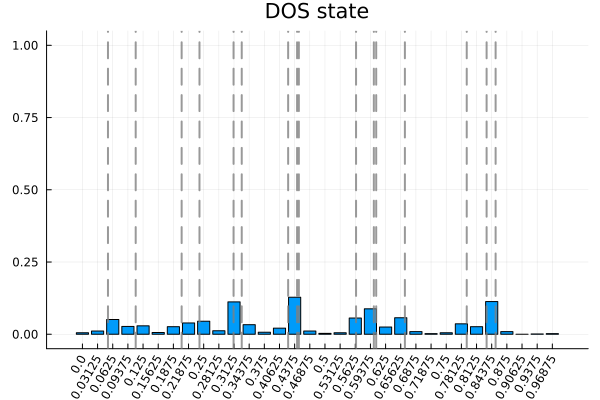

In [12]:
# Purified maximally mixed state

n_times = 5 # dimension time register
eig_idx = 3 # index of the eigenvalue to be read out
nshots = 1000

# Create diagonal matrix, rotate it, and find again eigenvalues and eigenvectors
# hamiltonian_matrix = diagm([0.125, 0.375, 0.4375, 0.75])
hamiltonian_matrix = diagm(sort(rand(Float64, 2^4)))

# rotation_matrix = I
# rotation_matrix = eigen(rand_unitary(length(diag(hamiltonian_matrix)))).vectors
rotation_matrix = rand_unitary(length(diag(hamiltonian_matrix)))

hamiltonian_matrix_rot = rotation_matrix * hamiltonian_matrix * rotation_matrix'
eigenvalues, eigenvectors = eigen(hamiltonian_matrix_rot) # the i-th eigenvector is eigenvectors[:, i]
unitary = exp(1im * 2π * hamiltonian_matrix_rot)

dos_state, counts_register_after_qpe = prepare_dos_encoded_state(unitary, n_times; nshots=nshots, extended_output=true, focussed_output=true)
println(dos_state)

xx = [bfloat_r(x-1, nbits=n_times) for x in 1:2^n_times] # same as [(x-1)/2^n_times for x in 1:2^n_times]
Plots.plot([(x-1)/2^n_times for x in 1:2^n_times], counts_register_after_qpe, legend=false, title="DOS state", xrotation=60, ylims=(-0.05, 1.05), seriestype=:bar)
Plots.plot!([real(i) for i in eigenvalues], color=:gray, label="", seriestype=:vline, linestyle=:dash, linewidth=2, alpha=0.8)
xticks!(xx, string.(xx))

### Yao QPE example

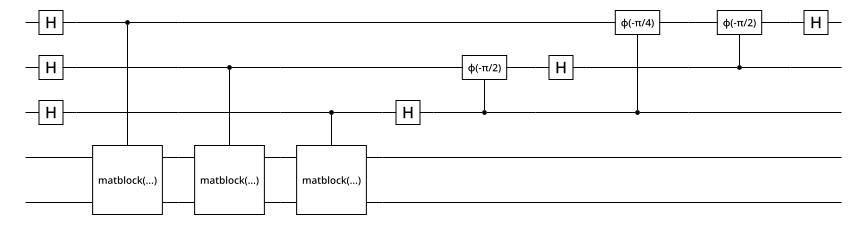

In [13]:
ControlU(n, m, U) = chain(n+m, control(k, n+1:n+m=>matblock(U^(2^(k-1)))) for k in 1:n)
PE(n, m, U) =
    chain(n+m, # total number of the qubits
        subroutine(circ_Hn(n), 1:n), # apply H in local scope
        ControlU(n, m, U),
        subroutine(circ_qft(n)', 1:n))

PE(3, 2, circ_haar_random_unitary(2)) |> YaoPlots.plot

In [14]:
N, M = 4, 1 # n_times, n_qubits
P = eigen(rand_unitary(1<<M)).vectors
θ = 0.75
# θ = Int(0b110) / 1<<N
phases = rand(1<<M)
phases[0b000+1] = θ
U = P * Diagonal(exp.(2π * im * phases)) * P'
psi = P[:, 1];

In [15]:
phases

2-element Vector{Float64}:
 0.75
 0.010006239330624056

In [16]:
r = join(ArrayReg(psi), zero_state(N))
r |> PE(N, M, U)
results = measure(r, 1:N; nshots=1)
# counts = [count(x->x==i, results) for i in 0:2^(N)-1] / 1000

1-element Vector{DitStr{2, 4, Int64}}:
 0011 ₍₂₎

In [17]:
using BitBasis
estimated_phase = bfloat(results[]; nbits=N)

0.75